# Import all the necessary libraries

In [1]:
# !pip3 install catboost
# !pip3 install xgboost

In [2]:
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import catboost as cb

from sklearn.preprocessing import OneHotEncoder, RobustScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.feature_selection import mutual_info_regression
from sklearn.linear_model import Ridge, HuberRegressor, LinearRegression
from sklearn.svm import SVR
from sklearn.cluster import KMeans
from scipy.stats import skew, norm, probplot
from xgboost import XGBRegressor
from mlxtend.regressor import StackingCVRegressor

from scipy import stats
from scipy.stats import norm, skew #for some statistics

warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)
sns.set_style('darkgrid')

# Load the dataset

In [3]:
train_data = pd.read_csv("train_data.csv")
test_data = pd.read_csv("test_data.csv")

# Creating a copy of the dataframe to avoid indices conflicts in future
copy_train = train_data.copy()
copy_test = test_data.copy()

In [4]:
copy_train.head(10)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
5,6,50,RL,85.0,14115,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,1.5Fin,5,5,1993,1995,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,Wood,Gd,TA,No,GLQ,732,Unf,0,64,796,GasA,Ex,Y,SBrkr,796,566,0,1362,1,0,1,1,1,1,TA,5,Typ,0,NaN,Attchd,1993.0,Unf,2,480,TA,TA,Y,40,30,0,320,0,0,NaN,MnPrv,Shed,700,10,2009,WD,Normal,143000
6,7,20,RL,75.0,10084,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Somerst,Norm,Norm,1Fam,1Story,8,5,2004,2005,Gable,CompShg,VinylSd,VinylSd,Stone,186.0,Gd,TA,PConc,Ex,TA,Av,GLQ,1369,Unf,0,317,1686,GasA,Ex,Y,SBrkr,1694,0,0,1694,1,0,2,0,3,1,Gd,7,Typ,1,Gd,Attchd,2004.0,RFn,2,636,TA,TA,Y,255,57,0,0,0,0,NaN,NaN,NaN,0,8,2007,WD,Normal,307000
7,8,60,RL,NaN,10382,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NWAmes,PosN,Norm,1Fam,2Story,7,6,1973,1973,Gable,CompShg,HdBoard,HdBoard,Stone,240.0,TA,TA,CBlock,Gd,TA,Mn,ALQ,859,BLQ,32,216,1107,GasA,Ex,Y,SBrkr,1107,983,0,2090,1,0,2,1,3,1,TA,7,Typ,2,TA,Attchd,1973.0,RFn,2,484,TA,TA,Y,235,204,228,0,0,0,NaN,NaN,Shed,350,11,2009,WD,Normal,200000
8,9,50,RM,51.0,6120,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Artery,Norm,1Fam,1.5Fin,7,5,1931,1950,Gable,CompShg,BrkFace,Wd Shng,None,0.0,TA,TA,BrkTil,TA,TA,No,Unf,0,Unf,0,952,952,GasA,Gd,Y,FuseF,1022,752,0,1774,0,0,2,0,2,2,TA,8,Min1,2,TA,Detchd,1931.0,Unf,2,468,Fa,TA,Y,90,0,205,0,0,0,NaN,NaN,NaN,0,4,2008,WD,Abnorml,129900
9,10,190,RL,50.0,7420,Pave,NaN,Reg,Lvl,AllPub,Corner,Gtl,BrkSide,Artery,Artery,2fmCon,1.5Unf,5,6,1939,1950,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,BrkTil,TA,TA,No,GLQ,851,Unf,0,140,991,Gas

In [5]:
copy_test.head(10)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,GasA,TA,Y,SBrkr,896,0,0,896,0.0,0.0,1,0,2,1,TA,5,Typ,0,NaN,Attchd,1961.0,Unf,1.0,730.0,TA,TA,Y,140,0,0,0,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,GasA,TA,Y,SBrkr,1329,0,0,1329,0.0,0.0,1,1,3,1,Gd,6,Typ,0,NaN,Attchd,1958.0,Unf,1.0,312.0,TA,TA,Y,393,36,0,0,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,GLQ,791.0,Unf,0.0,137.0,928.0,GasA,Gd,Y,SBrkr,928,701,0,1629,0.0,0.0,2,1,3,1,TA,6,Typ,1,TA,Attchd,1997.0,Fin,2.0,482.0,TA,TA,Y,212,34,0,0,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,6,1998,1998,Gable,CompShg,VinylSd,VinylSd,BrkFace,20.0,TA,TA,PConc,TA,TA,No,GLQ,602.0,Unf,0.0,324.0,926.0,GasA,Ex,Y,SBrkr,926,678,0,1604,0.0,0.0,2,1,3,1,Gd,7,Typ,1,Gd,Attchd,1998.0,Fin,2.0,470.0,TA,TA,Y,360,36,0,0,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,Inside,Gtl,StoneBr,Norm,Norm,TwnhsE,1Story,8,5,1992,1992,Gable,CompShg,HdBoard,HdBoard,None,0.0,Gd,TA,PConc,Gd,TA,No,ALQ,263.0,Unf,0.0,1017.0,1280.0,GasA,Ex,Y,SBrkr,1280,0,0,1280,0.0,0.0,2,0,2,1,Gd,5,Typ,0,NaN,Attchd,1992.0,RFn,2.0,506.0,TA,TA,Y,0,82,0,0,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal
5,1466,60,RL,75.0,10000,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,5,1993,1994,Gable,CompShg,HdBoard,HdBoard,None,0.0,TA,TA,PConc,Gd,TA,No,Unf,0.0,Unf,0.0,763.0,763.0,GasA,Gd,Y,SBrkr,763,892,0,1655,0.0,0.0,2,1,3,1,TA,7,Typ,1,TA,Attchd,1993.0,Fin,2.0,440.0,TA,TA,Y,157,84,0,0,0,0,NaN,NaN,NaN,0,4,2010,WD,Normal
6,1467,20,RL,NaN,7980,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,1Story,6,7,1992,2007,Gable,CompShg,HdBoard,HdBoard,None,0.0,TA,Gd,PConc,Gd,TA,No,ALQ,935.0,Unf,0.0,233.0,1168.0,GasA,Ex,Y,SBrkr,1187,0,0,1187,1.0,0.0,2,0,3,1,TA,6,Typ,0,NaN,Attchd,1992.0,Fin,2.0,420.0,TA,TA,Y,483,21,0,0,0,0,NaN,GdPrv,Shed,500,3,2010,WD,Normal
7,1468,60,RL,63.0,8402,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,5,1998,1998,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,Unf,0.0,Unf,0.0,789.0,789.0,GasA,Gd,Y,SBrkr,789,676,0,1465,0.0,0.0,2,1,3,1,TA,7,Typ,1,Gd,Attchd,1998.0,Fin,2.0,393.0,TA,TA,Y,0,75,0,0,0,0,NaN,NaN,NaN,0,5,2010,WD,Normal
8,1469,20,RL,85.0,10176,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,1Story,7,5,1990,1990,Gable,CompShg,HdBoard,HdBoard,None,0.0,TA,TA,PConc,Gd,TA,Gd,GLQ,637.0,Unf,0.0,663.0,1300.0,GasA,Gd,Y,SBrkr,1341,0,0,1341,1.0,0.0,1,1,2,1,Gd,5,Typ,1,Po,Attchd,1990.0,Unf,2.0,506.0,TA,TA,Y,192,0,0,0,0,0,NaN,NaN,NaN,0,2,2010,WD,Normal
9,1470,20,RL,70.0,8400,Pave,NaN,Reg,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,4,5,1970,1970,Gable,CompShg,

In [6]:
sample_submission= pd.read_csv("sample_submission.csv")

In [7]:
sample_submission.head(5)

,Id,SalePrice
0,1461,169277.052498
1,1462,187758.393989
2,1463,183583.683570
3,1464,179317.477511
4,1465,150730.079977


This means that we have to keep the id. Because it will be included in the finals submission and the target variable is the **Salesprice**.

In [8]:
housing_dataset = copy_train
test_dataset = copy_test

# Data Outliers Visualization

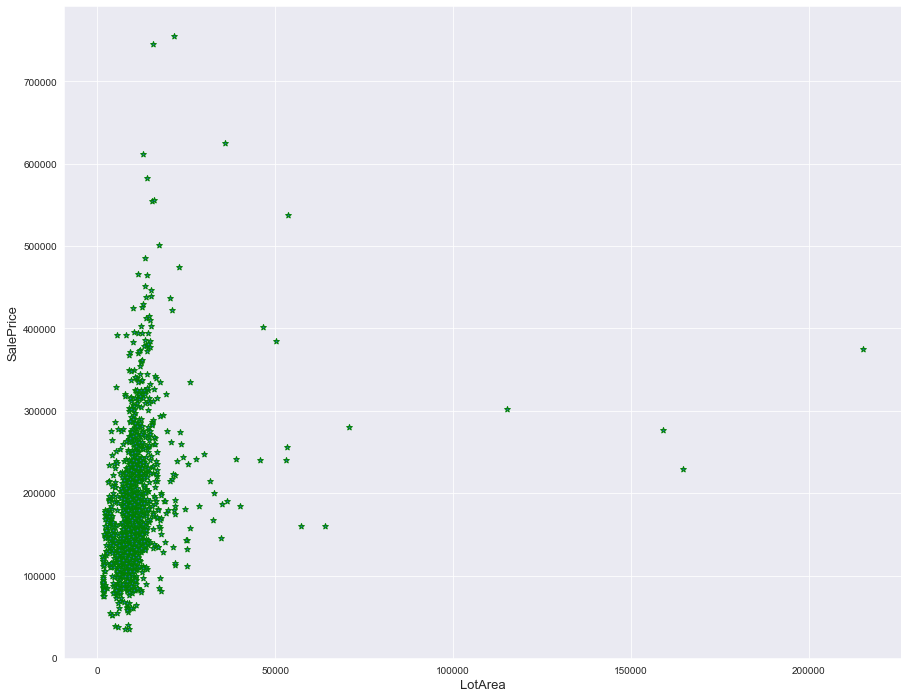

In [9]:
#Identifying the outliers by comparing the feature "LotArea" with SalePrice.

fig, ax = plt.subplots(figsize=(15, 12))
ax.scatter(x = housing_dataset['LotArea'], y = housing_dataset['SalePrice'], marker = "*", edgecolors = "Green")
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('LotArea', fontsize=13)
plt.show()

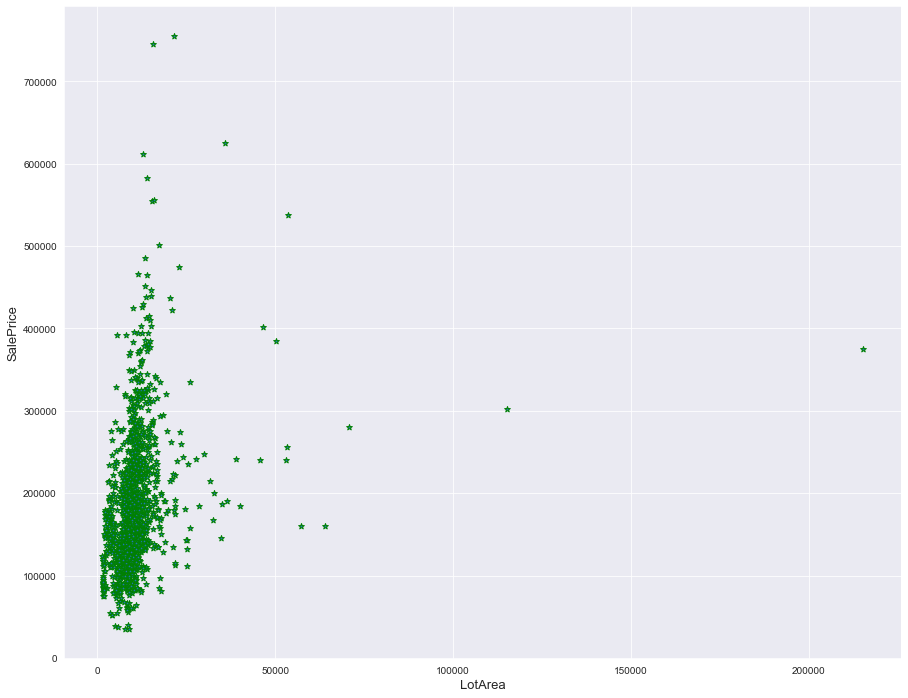

In [10]:
#Deleting outliers by defining the range
housing_dataset = housing_dataset.drop(housing_dataset[(housing_dataset['LotArea']>100000) & (housing_dataset['SalePrice']<300000)].index)

#Lets plot the graph again to see if the outliers are removed.
fig, ax = plt.subplots(figsize=(15, 12))
ax.scatter(housing_dataset['LotArea'], housing_dataset['SalePrice'], marker = "*", edgecolors = "Green")
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('LotArea', fontsize=13)
plt.show()

# Clean the Data

In [11]:
Current_Saleprice = housing_dataset['SalePrice']

# Save the saleprice in a variable for later comparision,
# and since we need to predict it, drop it from the current housing_dataset
housing_dataset = housing_dataset.drop(['SalePrice'],axis=1)

# set index to ID
housing_dataset = housing_dataset.set_index('Id')
test_dataset = test_dataset.set_index('Id')

housing_dataset.shape

(1458, 79)

In [12]:
list_of_null_values = []

for col in housing_dataset.columns:
    null = housing_dataset[col].isnull().sum()
    test_null = test_dataset[col].isnull().sum()
    if null != 0 or test_null != 0:
        list_of_null_values.append([col,null,test_null])
        
null_dataframe = pd.DataFrame(list_of_null_values,columns=['Feature_Name','Null','Test_Null'])
null_dataframe.set_index('Feature_Name')
null_dataframe['Total_Null'] = null_dataframe['Null'] + null_dataframe['Test_Null']


## Missing value visualization

-------------------------
Total number of columns with null values:
34
-------------------------
Total number of null values:
13957
-------------------------


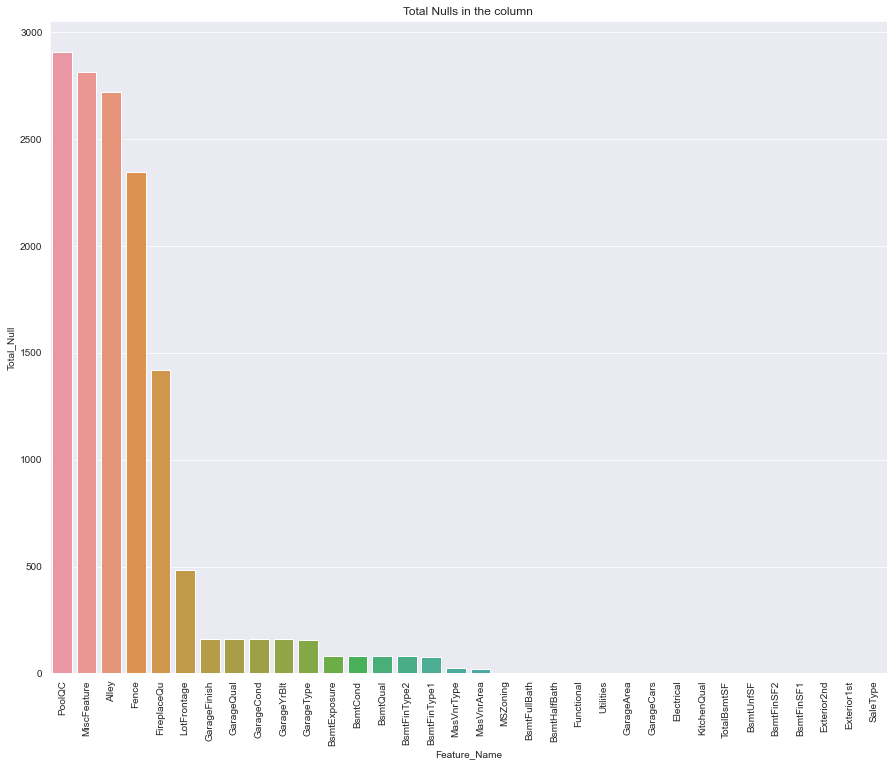

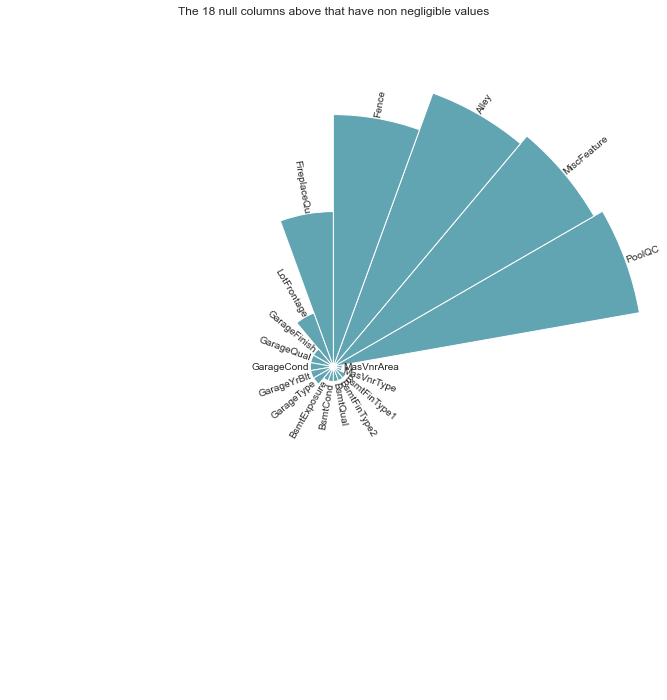

In [13]:

print("-------------------------")
print("Total number of columns with null values:")
print(len(null_dataframe))
print("-------------------------")
print("Total number of null values:")
print(null_dataframe['Total_Null'].sum(axis=0))
print("-------------------------")

f, ax = plt.subplots(figsize=(15, 12))
sns.set_palette(sns.color_palette("pastel"))
sns.barplot(data=null_dataframe.sort_values(by='Total_Null',ascending = False), x='Feature_Name',y='Total_Null')

plt.xticks(rotation = 90)
plt.title("Total Nulls in the column")
plt.show()

# Sort the null values
null_dataframe = null_dataframe.sort_values(by=['Total_Null'], ascending = False)

# drop the rows with very minor number of null values for visualization purpose (the rows are kept in the main housing_dataset) 
sorted_null_df = null_dataframe.drop(null_dataframe[null_dataframe['Total_Null'] <= 20].index)

# set figure size
plt.figure(figsize=(15, 12))

# plot polar axis
ax = plt.subplot(111, polar=True)

# remove grid
plt.axis('off')
plt.title("The 18 null columns above that have non negligible values") 

# Set the coordinates limits
upperLimit = 100
lowerLimit = 30

# Compute max and min in the dataset
max = sorted_null_df['Total_Null'].max()

# Let's compute heights: they are a conversion of each item value (Total_Null column value) in those new coordinates
# In our example, 0 in the dataset will be converted to the lowerLimit (10)
# The maximum will be converted to the upperLimit (100)
slope = (max - lowerLimit) / max
heights = slope * sorted_null_df.Total_Null + lowerLimit

# Compute the width of each bar. In total we have 2*Pi = 360°
width = 2*np.pi / len(sorted_null_df.index)

# Compute the angle each bar is centered on:
indexes = list(range(1, len(sorted_null_df.index)+1))
angles = [element * width for element in indexes]
angles

ax.tick_params(axis='x', labelrotation=10)

# Draw bars
bars = ax.bar(
    x=angles, 
    height=heights, 
    width=width, 
    bottom=lowerLimit,
    linewidth=1, 
    edgecolor="white",
    color="#61a4b2"
)

# little space between the bar and the label
labelPadding = 10

# Add labels
for bar, angle, height, label in zip(bars,angles, heights, sorted_null_df["Feature_Name"]):

    # Labels are rotated. Rotation must be specified in degrees :(
    rotation = np.rad2deg(angle)

    # Flip some labels upside down
    alignment = ""
    if angle >= np.pi/2 and angle < 3*np.pi/2:
        alignment = "right"
        rotation = rotation + 180
    else: 
        alignment = "left"

    # Finally add the labels
    ax.text(
        x=angle, 
        y=lowerLimit + bar.get_height() + labelPadding, 
        s=label, 
        ha=alignment, 
        va='center', 
        rotation=rotation, 
        rotation_mode="anchor")
    



<AxesSubplot:>

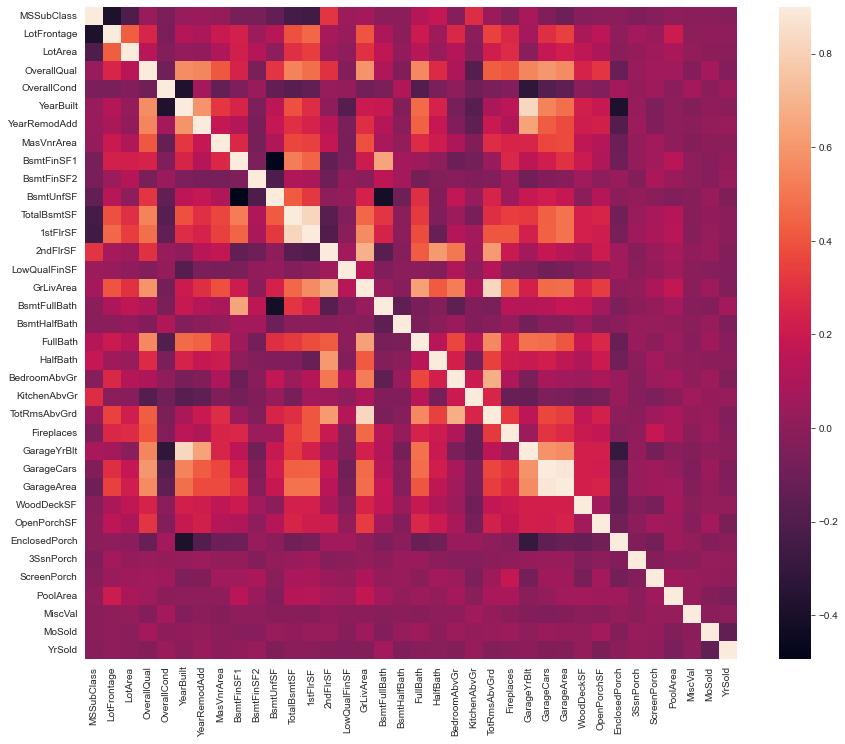

In [14]:
#Correlation map to see how features are correlated with SalePrice
corrmat = housing_dataset.corr()
plt.subplots(figsize=(15,12))
sns.heatmap(corrmat, vmax=0.9, square=True)

## Imputing Missing Values

In [15]:
# Let's combine our test and training dataset together for further processing
Complete_Test_and_Train_Data = pd.concat([housing_dataset,test_dataset],axis=0).reset_index(drop=True)

### MSZoning (the zoning classification in general): 
The value 'RL' is by far the most popular (MODE). As a result, we can use 'RL' to fill in any missing data in this column.

In [16]:
Complete_Test_and_Train_Data['MSZoning'] = Complete_Test_and_Train_Data['MSZoning'].fillna(Complete_Test_and_Train_Data['MSZoning'].mode()[0])

### LotFrontage : 
Because the area of each street connected to the house property is most likely similar to the area of other houses in the neighborhood, we may fill in missing numbers by using the community's median LotFrontage.

In [17]:
# Sort by neighborhood, then use the median Lot value to fill up the blanks. All of the neighborhood's frontage
Complete_Test_and_Train_Data["LotFrontage"] = Complete_Test_and_Train_Data.groupby("Neighborhood")["LotFrontage"].transform(
    lambda x: x.fillna(x.median()))

### Alley : 
Data description says NA means "no alley access"

In [18]:
Complete_Test_and_Train_Data["Alley"] = Complete_Test_and_Train_Data["Alley"].fillna("None")

### Utilities : 
For this categorical feature all records are "AllPub", except for one "NoSeWa" and 2 NA . Since the house with 'NoSewa' is in the training set, this feature won't help in predictive modelling. We can then safely remove it.

In [19]:
Complete_Test_and_Train_Data = Complete_Test_and_Train_Data.drop(['Utilities'], axis=1)


### PoolQC : 
Data description says NA means "No Pool". That make sense, given the huge ratio of missing value (+99%) and majority of houses have no Pool at all in general.

In [20]:
Complete_Test_and_Train_Data["PoolQC"] = Complete_Test_and_Train_Data["PoolQC"].fillna("None")

### MiscFeature : 
Data description says NA means "no misc feature"

In [21]:
Complete_Test_and_Train_Data["MiscFeature"] = Complete_Test_and_Train_Data["MiscFeature"].fillna("None")

### Fence : 
Data description says NA means "no fence"

In [22]:
Complete_Test_and_Train_Data["Fence"] = Complete_Test_and_Train_Data["Fence"].fillna("None")

### FireplaceQu : 
Data description says NA means "no fireplace"

In [23]:
Complete_Test_and_Train_Data["FireplaceQu"] = Complete_Test_and_Train_Data["FireplaceQu"].fillna("None")

### GarageType, GarageFinish, GarageQual and GarageCond : 
Replacing missing data with None

In [24]:
for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'):
    Complete_Test_and_Train_Data[col] = Complete_Test_and_Train_Data[col].fillna('None')

### GarageYrBlt, GarageArea and GarageCars : 
Replacing missing data with 0 (Since No garage = no cars in such garage.)

In [25]:
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    Complete_Test_and_Train_Data[col] = Complete_Test_and_Train_Data[col].fillna(0)

### BsmtFinSF1, BsmtFinSF2, BsmtUnfSF, TotalBsmtSF, BsmtFullBath and BsmtHalfBath : 
missing values are likely zero for having no basement

In [26]:
for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
    Complete_Test_and_Train_Data[col] = Complete_Test_and_Train_Data[col].fillna(0)

### BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1 and BsmtFinType2 : 
For all these categorical basement-related features, NaN means that there is no basement.

In [27]:
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    Complete_Test_and_Train_Data[col] = Complete_Test_and_Train_Data[col].fillna('None')

### MasVnrArea and MasVnrType : 
NA most likely means no masonry veneer for these houses. We can fill 0 for the area and None for the type.

In [28]:
Complete_Test_and_Train_Data["MasVnrType"] = Complete_Test_and_Train_Data["MasVnrType"].fillna("None")
Complete_Test_and_Train_Data["MasVnrArea"] = Complete_Test_and_Train_Data["MasVnrArea"].fillna(0)

### Functional : 
data description says NA means typical

In [29]:
Complete_Test_and_Train_Data["Functional"] = Complete_Test_and_Train_Data["Functional"].fillna("Typ")

### Electrical : 
It has one NA value. Since this feature has mostly 'SBrkr', we can set that for the missing value.

In [30]:
Complete_Test_and_Train_Data['Electrical'] = Complete_Test_and_Train_Data['Electrical'].fillna(Complete_Test_and_Train_Data['Electrical'].mode()[0])

### KitchenQual: 
Only one NA value, and same as Electrical, we set 'TA' (which is the most frequent) for the missing value in KitchenQual.

In [31]:
Complete_Test_and_Train_Data['KitchenQual'] = Complete_Test_and_Train_Data['KitchenQual'].fillna(Complete_Test_and_Train_Data['KitchenQual'].mode()[0])

### Exterior1st and Exterior2nd :
Again Both Exterior 1 & 2 have only one missing value. We will just substitute in the most common string

In [32]:
Complete_Test_and_Train_Data['Exterior1st'] = Complete_Test_and_Train_Data['Exterior1st'].fillna(Complete_Test_and_Train_Data['Exterior1st'].mode()[0])
Complete_Test_and_Train_Data['Exterior2nd'] = Complete_Test_and_Train_Data['Exterior2nd'].fillna(Complete_Test_and_Train_Data['Exterior2nd'].mode()[0])


### SaleType : 
Fill in again with most frequent which is "WD"

In [33]:
Complete_Test_and_Train_Data['SaleType'] = Complete_Test_and_Train_Data['SaleType'].fillna(Complete_Test_and_Train_Data['SaleType'].mode()[0])

### MSSubClass : 
Na most likely means No building class. We can replace missing values with None

In [34]:
Complete_Test_and_Train_Data['MSSubClass'] = Complete_Test_and_Train_Data['MSSubClass'].fillna("None")

### Check if there are any more null values in the data set

In [35]:
list_of_null_values = []

for col in Complete_Test_and_Train_Data.columns:
    null = Complete_Test_and_Train_Data[col].isnull().sum()
    if null != 0:
        list_of_null_values.append([col,null])
        
null_dataframe = pd.DataFrame(list_of_null_values,columns=['Feature_Name','Total_Null'])
null_dataframe.set_index('Feature_Name')

print("-------------------------")
print("Total number of columns with null values:")
print(len(null_dataframe))
print("-------------------------")
print("Total number of null values:")
print(null_dataframe['Total_Null'].sum(axis=0))
print("-------------------------")

Complete_Test_and_Train_Data.shape


-------------------------
Total number of columns with null values:
0
-------------------------
Total number of null values:
0
-------------------------


(2917, 78)

In [36]:
Complete_Test_and_Train_Data.isnull().sum().sum()

0

In [37]:
Complete_Test_and_Train_Data.index = Complete_Test_and_Train_Data.index - 1

# Feature Engineering
Log-transformation of skewed target variable

Log-transformation is a technique used to perform Feature Transformation. It is one of the many techniques that can be used to transform the features so that they are treated equally.

Why do we want models to treat them equally? It is because when we input these features to the model, there is a posibillity that an larger value in an imbalance feature will influence the result more and further affect the model performance. This is not something we will want as each and every row of data are equally important as a predictor.

We wouldn't want the model to prioritize predicting only data with higher sale prices. Hence, scaling and transforming is important for algorithms where distance between the data points is important.

We picked log-transformation here as it has the power to alter the skewness of a distribution towards normality. You can observe how log-transformation of a feature can transform its distribution and scale.


 mu = 180921.20 and sigma = 79415.29



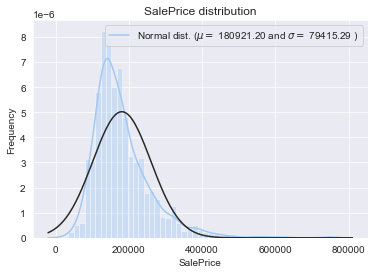

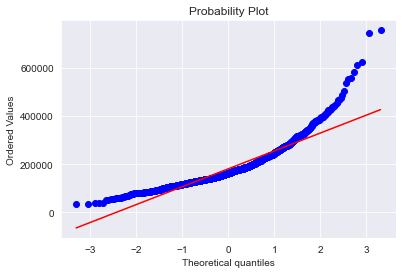

In [38]:
# Distribution plot
y = copy_train['SalePrice']
sns.distplot(y , fit=norm);

(mu, sigma) = norm.fit(y)
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

# QQ-plot
fig = plt.figure()
res = probplot(y, plot=plt)
plt.show()

The first plot is a distribution plot where we compare the distribution of our target variable with a normal distribution.
We can easily see it is right-skewed.

The Q-Q plot below plots the quantiles of our target feature against the quantiles of a normal distribution.
We can also easily see the skewness in the target feature.

Notice how it changes after we apply log transformation onto our feature.

In [39]:
y = np.log( copy_train['SalePrice'])


 mu = 12.02 and sigma = 0.40



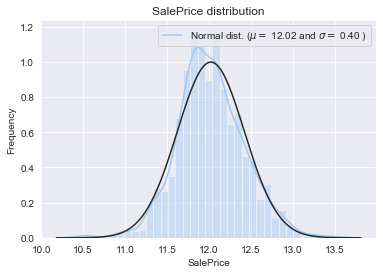

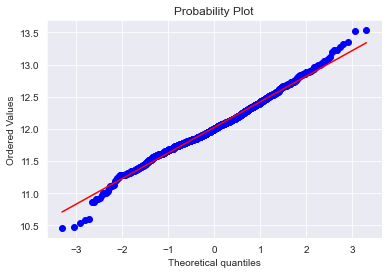

0       12.247694
1       12.109011
2       12.317167
3       11.849398
4       12.429216
          ...    
1455    12.072541
1456    12.254863
1457    12.493130
1458    11.864462
1459    11.901583
Name: SalePrice, Length: 1460, dtype: float64

In [40]:
sns.distplot(y , fit=norm);
(mu, sigma) = norm.fit(y)
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

fig = plt.figure()
res = probplot(y, plot=plt)
plt.show()

y

#### Transforming some numerical variables that are really categorical

In [41]:
#MSSubClass=The building class
Complete_Test_and_Train_Data['MSSubClass'] = Complete_Test_and_Train_Data['MSSubClass'].apply(str)


#Changing OverallCond into a categorical variable
Complete_Test_and_Train_Data['OverallCond'] = Complete_Test_and_Train_Data['OverallCond'].astype(str)


#Year and month sold are transformed into categorical features.
Complete_Test_and_Train_Data['YrSold'] = Complete_Test_and_Train_Data['YrSold'].astype(str)
Complete_Test_and_Train_Data['MoSold'] = Complete_Test_and_Train_Data['MoSold'].astype(str)

#### Label Encoding some categorical variables that may contain information in their ordering set

In [42]:
from sklearn.preprocessing import LabelEncoder
cols = ('FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 
        'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1', 
        'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
        'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 'OverallCond', 
        'YrSold', 'MoSold')
# process columns, apply LabelEncoder to categorical features
for c in cols:
    lbl = LabelEncoder() 
    lbl.fit(list(Complete_Test_and_Train_Data[c].values)) 
    Complete_Test_and_Train_Data[c] = lbl.transform(list(Complete_Test_and_Train_Data[c].values))

# shape        
print('Shape all_data: {}'.format(Complete_Test_and_Train_Data.shape))


Shape all_data: (2917, 78)


#### Adding one more important feature
Since area related features are very important to determine house prices, we add one more feature which is the total area of basement, first and second floor areas of each house

In [43]:
# Adding total sqfootage feature 
Complete_Test_and_Train_Data['TotalSF'] = Complete_Test_and_Train_Data['TotalBsmtSF'] + Complete_Test_and_Train_Data['1stFlrSF'] + Complete_Test_and_Train_Data['2ndFlrSF']

#### Skewed features

In [44]:
numeric_feats = Complete_Test_and_Train_Data.dtypes[Complete_Test_and_Train_Data.dtypes != "object"].index

# Check the skew of all numerical features
skewed_feats = Complete_Test_and_Train_Data[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(10)


Skew in numerical features: 



,Skew
MiscVal,21.962846
PoolArea,16.892477
LotArea,12.361741
LowQualFinSF,12.084539
3SsnPorch,11.372080
LandSlope,4.970371
KitchenAbvGr,4.300550
BsmtFinSF2,4.145847
EnclosedPorch,4.002344
ScreenPorch,3.945101


#### Box Cox Transformation of (highly) skewed features
We use the scipy function boxcox1p which computes the Box-Cox transformation of  1+x .

Note that setting  λ=0  is equivalent to log1p used above for the target variable.



In [45]:
skewness = skewness[abs(skewness) > 0.75]
print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))

from scipy.special import boxcox1p
skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    #all_data[feat] += 1
    Complete_Test_and_Train_Data[feat] = boxcox1p(Complete_Test_and_Train_Data[feat], lam)
    
#all_data[skewed_features] = np.log1p(all_data[skewed_features])

There are 59 skewed numerical features to Box Cox transform


#### Getting dummy categorical features

In [46]:
Complete_Test_and_Train_Data = pd.get_dummies(Complete_Test_and_Train_Data)
print(Complete_Test_and_Train_Data.shape)


(2917, 221)


#### Getting the new train and test sets.



In [96]:
ntrain = housing_dataset.shape[0]
ntest = test_dataset.shape[0]
copy_train = Complete_Test_and_Train_Data[:ntrain]
copy_test = Complete_Test_and_Train_Data[ntrain:]
copy_test


,MSSubClass,LotFrontage,LotArea,Street,Alley,LotShape,LandSlope,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,HeatingQC,CentralAir,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscVal,MoSold,YrSold,TotalSF,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,LandContour_Bnk,LandContour_HLS,LandContour_Low,LandContour_Lvl,LotConfig_Corner,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,Neighborhood_Blmngtn,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition1_Artery,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,Condition2_Artery,Condition2_Feedr,Condition2_Norm,Condition2_PosA,Condition2_PosN,Condition2_RRAe,Condition2_RRAn,Condition2_RRNn,BldgType_1Fam,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1.5Fin,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,RoofStyle_Flat,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,RoofMatl_ClyTile,RoofMatl_CompShg,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,Exterior1st_AsbShng,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsbShng,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,MasVnrType_BrkCmn,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,Foundation_BrkTil,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,Heating_Floor,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,Electrical_FuseA,Electrical_FuseF,Electrical_FuseP,Electrical_Mix,Electrical_SBrkr,GarageType_2Types,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_None,MiscFeature_Gar2,MiscFeature_None,MiscFeature_Othr,MiscFeature_Shed,MiscFeature_TenC,SaleType_COD,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
1457,2.055642,6.221214,20.479373,0.730463,0.730463,1.540963,0.000000,2.055642,2.055642,14.121376,14.121376,0.000000,1.540963,1.820334,1.820334,1.820334,1.540963,2.055642,10.105326,1.540963,7.397498,8.780689,11.775114,1.820334,0.730463,11.818680,0.000000,0.0,11.818680,0.000000,0.000000,0.730463,0.000000,1.194318,0.730463,1.540963,2.055642,2.259674,0.000000,1.540963,14.121376,1.540963,0.730463,11.259868,2.055642,2.055642,1.194318,7.338607,0.000000,0.0,0.0,7.020909,0.0,1.540963,1.194318,0.000000,2.602594,1.820334,13.

In [48]:
# #Reducing the number of components using Principal Component Analysis to three components

# pca_components = 5
# decreased_data = PCA().fit_transform(copy_train)
# decreased_test = PCA().fit_transform(copy_test)



# Modeling

In [49]:
#We start the model analysis and compare the models 
#multi- linear regression
from sklearn import linear_model
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV,LogisticRegression
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.model_selection import KFold # for repeated K-fold cross validation
from sklearn.model_selection import cross_val_score # score evaluation
from sklearn.model_selection import cross_val_predict # prediction



In [52]:
# # Initialize linear regression instance


# lin_reg = LinearRegression()

# # Create empty list to store RMSE for each iteration
# rmse_list = []

# # Loop through different count of principal components for linear regression
# for i in range(1, decreased_data.shape[1]+1):
#     rmse_score = -1 * cross_val_score(lin_reg, 
#                                       decreased_data[:,:i], # Use first k principal components
#                                       Current_Saleprice, 
#                                       cv=kfolds, 
#                                       scoring='neg_root_mean_squared_error').mean()
#     rmse_list.append(rmse_score/Current_Saleprice.max())

# f = plt.figure()
# f.set_figwidth(40)
# f.set_figheight(50)
# # Visual analysis - plot RMSE vs count of principal components used
# plt.plot(rmse_list, '-o')
# plt.xlabel('Number of principal components in regression')
# plt.ylabel('RMSE')
# plt.title('Quality')
# plt.xlim(xmin=-1);
# plt.xticks(np.arange(decreased_data.shape[1]), np.arange(1, decreased_data.shape[1]+1))
# plt.axhline(y=rmse_training.all(), color='g', linestyle='-');

# kfolds= KFold(10,True)

In [53]:
#Calculate root mean squared error
#As the range of the values is going to be 0 to Current_Saleprice.max() we divide the rmse by Current_Saleprice.max() 
#so we get the rmse value on a range from 0 to 1 for better analysing purposes.
def root_mean_squared_error(y_pred):
    return np.sqrt(mean_squared_error(y_pred,Current_Saleprice))/Current_Saleprice.max()

In [54]:
# Return root mean square error applied cross validation (Used for training prediction)

#As the range of the values is going to be 0 to Current_Saleprice.max() we divide the cross-validation-score by Current_Saleprice.max() 
#so we get the cross-validation-score value on a range from 0 to 1 for better analysing purposes.

def cross_validation_score(model):
    return np.sqrt(-cross_val_score(model, copy_train, Current_Saleprice, scoring="neg_mean_squared_error", cv=10)).mean()/Current_Saleprice.max()    

### Multiple regression

Linear regression is one of the most used regression algorithms so , it was a given to use this algorithm .

As there are multiple independent variables and just one target variable , we used multiple regression , where you can predict the value of the target variable using two or more independent variables.

In [55]:
# Initialize linear regression instance
multiple_regression = linear_model.LinearRegression()
#Training the model using the training data
multiple_regression.fit(copy_train,Current_Saleprice)

#Predicting the model on the training data itself
multiple_regression_y_pred = multiple_regression.predict(copy_train)

#root mean square error of the model
multiple_regression_rmse = root_mean_squared_error(multiple_regression_y_pred)

# Return root mean square error applied cross validation (Used for training prediction)
multiple_regression_cross_val_score = cross_validation_score(multiple_regression)


print("Root mean squared error of multi linear regression model : {0}".format(multiple_regression_rmse))

print("Cross validation score of multi linear regression model : {0}".format(multiple_regression_cross_val_score))

Root mean squared error of multi linear regression model : 0.03217635709508138
Cross validation score of multi linear regression model : 103387646.08672692


### Logistic Regression

Logistic regression is a statistical model used for analysis of the dataset. It predicts an outcome based on one or more independent variables.

In [56]:
# Initialize logistic regression instance
logistic_regression = linear_model.LogisticRegression()
#Training the model using the training data
logistic_regression.fit(copy_train,Current_Saleprice)

#Predicting the model on the training data itself
logistic_regression_y_pred = logistic_regression.predict(copy_train)

#root mean square error of the model
logistic_regression_rmse = root_mean_squared_error(logistic_regression_y_pred)

# Return root mean square error applied cross validation (Used for training prediction)
logistic_regression_cross_val_score = cross_validation_score(logistic_regression)


print("Root mean squared error of logistic regression model : {0}".format(logistic_regression_rmse))

print("Cross validation score of logistic regression model : {0}".format(logistic_regression_cross_val_score))

Root mean squared error of logistic regression model : 0.023488045222642178
Cross validation score of logistic regression model : 0.07220713937811833


(array([482., 727., 190.,  45.,   7.,   5.,   2.]),
 array([ 34900.        , 137771.42857143, 240642.85714286, 343514.28571429,
        446385.71428571, 549257.14285714, 652128.57142857, 755000.        ]),
 <BarContainer object of 7 artists>)

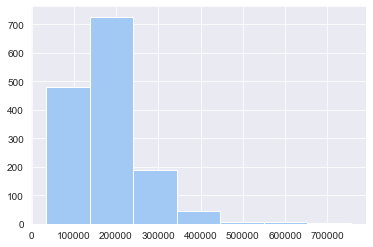

In [57]:
#plotting the saleprice values in a bar graph

plt.hist(logistic_regression_y_pred,bins=7)

### SVM

SVM (Support Vector Machine) is used in classification as well as regression purposes.
SVM is generally used for classification.

In [58]:
# Initialize SVM regression instance
svm_regression = svm.SVR().fit(copy_train,Current_Saleprice)
#Training the model using the training data
svm_regression.fit(copy_train,Current_Saleprice)

#Predicting the model on the training data itself
svm_regression_y_pred = svm_regression.predict(copy_train)

#root mean square error of the model
svm_regression_rmse = root_mean_squared_error(svm_regression_y_pred)

# Return root mean square error applied cross validation (Used for training prediction)
svm_regression_cross_val_score = cross_validation_score(svm_regression)


print("Root mean squared error of SVR regression model : {0}".format(svm_regression_rmse))

print("Cross validation score of SVR regression model : {0}".format(svm_regression_cross_val_score))

Root mean squared error of SVR regression model : 0.10779025662063173
Cross validation score of SVR regression model : 0.10732924792894331


(array([ 25., 123., 343., 454., 366., 127.,  20.]),
 array([162927.88110105, 162946.22550652, 162964.56991199, 162982.91431747,
        163001.25872294, 163019.60312841, 163037.94753389, 163056.29193936]),
 <BarContainer object of 7 artists>)

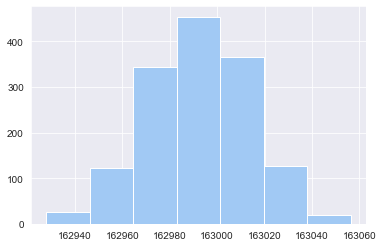

In [59]:
plt.hist(svm_regression_y_pred,bins=7)

### KNN

KNN (K-Nearest-Neighbors) is also a classification algorithm but can be used for regression purposes as well.


In [60]:
# Initialize KNN instance
knn = KNeighborsClassifier(n_neighbors=5)

#Training the model using the training data
knn.fit(copy_train,Current_Saleprice)

#Predicting the model on the training data itself
knn_y_pred = knn.predict(copy_train)

#root mean square error of the model
knn_rmse = root_mean_squared_error(knn_y_pred)

# Return root mean square error applied cross validation (Used for training prediction)
knn_cross_val_score = cross_validation_score(knn)


print("Root mean squared error of KNN  model : {0}".format(knn_rmse))

print("Cross validation score of KNN  model : {0}".format(knn_cross_val_score))

Root mean squared error of KNN  model : 0.08367669215904842
Cross validation score of KNN  model : 0.09100558073511443


(array([ 78., 399., 495., 313., 100.,  32.,  41.]),
 array([ 34900.,  76432., 117964., 159496., 201028., 242560., 284092.,
        325624.]),
 <BarContainer object of 7 artists>)

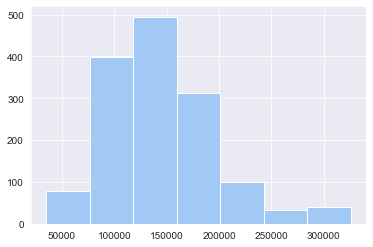

In [61]:
#plotting the saleprice values in a bar graph

plt.hist(knn_y_pred,bins=7)


### XGB Regressor 

XGB is an efficient implementation of the gradient boosting algorithm.

It consists of a class of ensemble machine learning models used for regression purposes.

In [62]:
# Initialize XGB Regressor instance
xgbr = XGBRegressor(verbosity=0,n_estimators=1000) 
#Training the model using the training data
xgbr.fit(copy_train, Current_Saleprice)

#Predicting the model on the training data itself
xgbr_y_pred = xgbr.predict(copy_train)

#root mean square error of the model
xgbr_rmse = root_mean_squared_error(xgbr_y_pred)

# Return root mean square error applied cross validation (Used for training prediction)
xgbr_cross_val_score = cross_validation_score(xgbr)


print("Root mean squared error of XGB Regressor   model : {0}".format(xgbr_rmse))

print("Cross validation score of XGB Regressor   model : {0}".format(xgbr_cross_val_score))

Root mean squared error of XGB Regressor   model : 8.496519835891651e-08
Cross validation score of XGB Regressor   model : 0.0368727553186069


(array([464., 750., 185.,  45.,   7.,   5.,   2.]),
 array([ 34899.953, 137771.39 , 240642.83 , 343514.25 , 446385.7  ,
        549257.1  , 652128.56 , 755000.   ], dtype=float32),
 <BarContainer object of 7 artists>)

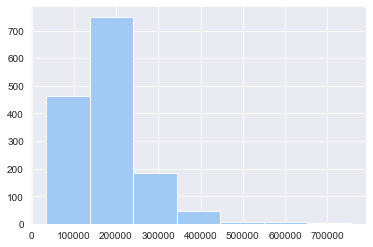

In [63]:
#plotting the saleprice values in a bar graph

plt.hist(xgbr_y_pred,bins=7)


## Gradient Boosting Regression

In [64]:
gbr = GradientBoostingRegressor(n_estimators=1000)

In [65]:
gbr.fit(copy_train, Current_Saleprice)

GradientBoostingRegressor(n_estimators=1000)

In [66]:
# Initialize Gradient Boosting Regression instance
gbr = GradientBoostingRegressor(n_estimators=1000)

#Training the model using the training data
gbr.fit(copy_train, Current_Saleprice)

#Predicting the model on the training data itself
gbr_y_pred = gbr.predict(copy_train)

#root mean square error of the model
gbr_rmse = root_mean_squared_error(gbr_y_pred)

# Return root mean square error applied cross validation (Used for training prediction)
gbr_cross_val_score = cross_validation_score(gbr)


print("Root mean squared error of Gradient Boosting Regression model : {0}".format(gbr_rmse))

print("Cross validation score of Gradient Boosting Regression model : {0}".format(gbr_cross_val_score))

Root mean squared error of Gradient Boosting Regression model : 0.004628913767736696
Cross validation score of Gradient Boosting Regression model : 0.032319806709157614


(array([468., 742., 189.,  44.,   8.,   5.,   2.]),
 array([ 35094.38847801, 137798.20710348, 240502.02572894, 343205.8443544 ,
        445909.66297987, 548613.48160533, 651317.30023079, 754021.11885626]),
 <BarContainer object of 7 artists>)

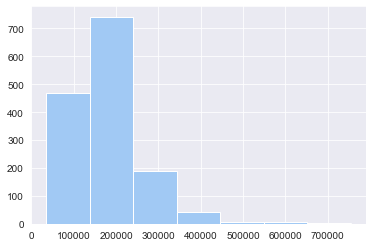

In [67]:
#plotting the saleprice values in a bar graph

plt.hist(gbr_y_pred,bins=7)


## Lasso Regression

In [68]:
# Initialize lasso regression instance
#Training the model using the training data
lasso_regression = LassoCV().fit(copy_train, Current_Saleprice)

#Predicting the model on the training data itself
lasso_regression_y_pred = lasso_regression.predict(copy_train)

#root mean square error of the model
lasso_regression_rmse = root_mean_squared_error(lasso_regression_y_pred)

# Return root mean square error applied cross validation (Used for training prediction)
lasso_regression_cross_val_score = cross_validation_score(lasso_regression)


print("Root mean squared error of Lasso regression model : {0}".format(lasso_regression_rmse))

print("Cross validation score of Lasso regression model : {0}".format(lasso_regression_cross_val_score))

Root mean squared error of Lasso regression model : 0.035666166938300964
Cross validation score of Lasso regression model : 0.04003455756185986


(array([ 22., 521., 575., 228.,  88.,  22.,   2.]),
 array([-14508.52337622,  65132.88348482, 144774.29034585, 224415.69720689,
        304057.10406793, 383698.51092897, 463339.91779   , 542981.32465104]),
 <BarContainer object of 7 artists>)

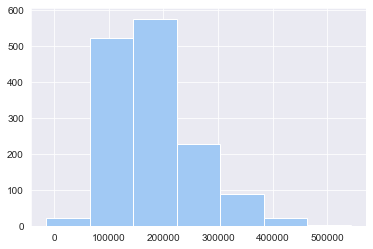

In [69]:
#plotting the saleprice values in a bar graph

plt.hist(lasso_regression_y_pred,bins=7)


## Ridge Regression

In [70]:
# Initialize lasso regression instance
#Training the model using the training data
ridge_regression = RidgeCV().fit(copy_train, Current_Saleprice)

#Predicting the model on the training data itself
ridge_regression_y_pred = ridge_regression.predict(copy_train)

#root mean square error of the model
ridge_regression_rmse = root_mean_squared_error(ridge_regression_y_pred)

# Return root mean square error applied cross validation (Used for training prediction)
ridge_regression_cross_val_score = cross_validation_score(ridge_regression)


print("Root mean squared error of Ridge regression model : {0}".format(ridge_regression_rmse))

print("Cross validation score of Ridge regression model : {0}".format(ridge_regression_cross_val_score))

Root mean squared error of Ridge regression model : 0.0359486103976169
Cross validation score of Ridge regression model : 0.040414078877110425


(array([ 30., 503., 536., 258.,  99.,  28.,   4.]),
 array([ -2847.41473966,  70364.90258546, 143577.21991059, 216789.53723572,
        290001.85456084, 363214.17188597, 436426.4892111 , 509638.80653622]),
 <BarContainer object of 7 artists>)

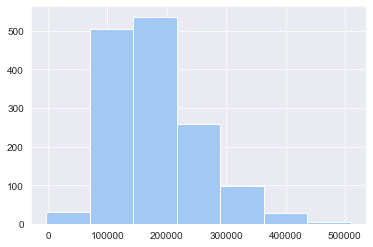

In [71]:
#plotting the saleprice values in a bar graph

plt.hist(ridge_regression_y_pred,bins=7)

## Stacking model:

In [76]:
# Initialize Stacking model instance
stack_model = StackingCVRegressor(regressors=(multiple_regression,logistic_regression, xgbr,
                                              gbr,lasso_regression,ridge_regression),
                                  meta_regressor=xgbr, use_features_in_secondary=True)


#Training the model using the training data
stack_model.fit(copy_train, Current_Saleprice)

#Predicting the model on the training data itself
stack_model_y_pred = stack_model.predict(copy_train)


In [77]:
#root mean square error of the model
stack_model_rmse = root_mean_squared_error(stack_model_y_pred)

# Return root mean square error applied cross validation (Used for training prediction)
stack_model_cross_val_score = cross_validation_score(stack_model)


print("Root mean squared error of Stacking model : {0}".format(stack_model_rmse))

print("Cross validation score of Stacking model : {0}".format(stack_model_cross_val_score))

Root mean squared error of Stacking model : 0.012420905745264244
Cross validation score of Stacking model : 0.03568137274433333


(array([514., 705., 182.,  37.,  13.,   5.,   2.]),
 array([ 39316.25, 141556.64, 243797.03, 346037.44, 448277.8 , 550518.2 ,
        652758.6 , 754999.  ], dtype=float32),
 <BarContainer object of 7 artists>)

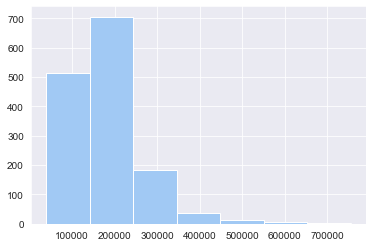

In [78]:
#plotting the saleprice values in a bar graph

plt.hist(stack_model_y_pred,bins=7)

In [ ]:
# output_df = pd.DataFrame({'Id': copy_test.index +4,
#                    'SalePrice': stack_model_house_price_prediction})
# output_df


In [ ]:
# output_df.to_csv(r'C:\Users\Checkout\Desktop\Submissions_Stack.csv', index=False)


## Observations:

1. As this was an ongoing competition , the one way of knowing your accuracy was to submit the output.csv file generated using each model on the kaggle competition.
2. After submitting , we compared the results from each regression model and proceeded with our analysis.
3. On kaggle , after submitting your results , you get a score on the leaderboard, lower the score better is your model.
4. The multiple regression model had a score of 0.94950.
5. The logistic regression model had a score of 0.27592.
6. The SVM model had a score of 0.41647.
7. The KNN model had a score of 0.36350.
8. The XGB Regressor model had a score of 0.45174.


- According to the observations , logistic regression model performed best across all the models, but that is still not  accurate enough.
- We would not proceed with SVM because it it generally used for classification purposes and this is not a classification problem.
- Further analysis needs to be done and different types of models need to be explored. 
- It is also possible that we would need to club/join two-three different kinds of models to achieve maximum accuracy.

In [120]:
#Comparison between models
#get decimal upto 4 values

def get_decimal(a):
    return ( format(int(a),'.4f'))

In [125]:
models_rmse = [multiple_regression_rmse,
                         logistic_regression_rmse,
                         ridge_regression_rmse,
                         lasso_regression_rmse,
                        gbr_rmse,
                        xgbr_rmse,
                        knn_rmse,
                         svm_regression_rmse,
                         stack_model_rmse]

In [126]:
models_cross_val_score =[multiple_regression_cross_val_score,
                         logistic_regression_cross_val_score,
                         ridge_regression_cross_val_score,
                         lasso_regression_cross_val_score,
                        gbr_cross_val_score,
                        xgbr_cross_val_score,
                        knn_cross_val_score,
                         svm_regression_cross_val_score,
                         stack_model_cross_val_score
                        ]

In [127]:
for i in range(len(models_rmse)):
    models_rmse[i] = format(models_rmse[i],'.4f')

print(models_rmse)

['0.0322', '0.0235', '0.0359', '0.0357', '0.0046', '0.0000', '0.0837', '0.1078', '0.0124']


In [128]:
for i in range(len(models_cross_val_score)):
    models_cross_val_score[i] = format(models_cross_val_score[i],'.4f')

print(models_cross_val_score)

['103387646.0867', '0.0722', '0.0404', '0.0400', '0.0323', '0.0369', '0.0910', '0.1073', '0.0357']


In [139]:
models = ['Linear Regression','Logistic Regression', 'Ridge Regression','Lasso Regression','Gradient Boosting Regression',
          'XGBR Regressor','KNN','SVM Regression','Stacking Model']

In [140]:
comparison_table = pd.DataFrame({'Models':models,
                               'rmse':models_rmse,
                               'cross_val_score':models_cross_val_score})

In [141]:
comparison_table = comparison_table.set_index(['Models'])

In [142]:
comparison_table

,rmse,cross_val_score
Models,,
Linear Regression,0.0322,103387646.0867
Logistic Regression,0.0235,0.0722
Ridge Regression,0.0359,0.0404
Lasso Regression,0.0357,0.0400
Gradient Boosting Regression,0.0046,0.0323
XGBR Regressor,0.0000,0.0369
KNN,0.0837,0.0910
SVM Regression,0.1078,0.1073
Stacking Model,0.0124,0.0357


In [151]:
from sklearn.linear_model import Lasso
model = Lasso()
alphas=[0.005,0.05,0.5,5,0,0.001,0.01,0.1,1]
lasso_cv = GridSearchCV(model, param_grid=dict(alpha=alphas))
lasso_cv.fit(copy_train,Current_Saleprice)

print(lasso_cv.best_estimator_)
print(lasso_cv.best_score_)


Lasso(alpha=5)
0.8235764036799462


In [ ]:
#Training the model using the training data
elastic_net_regression = ElasticNet().fit(copy_train,Current_Saleprice)
#Predicting the model on the training data itself
elastic_net_regression_y_pred = elastic_net_regression.predict(copy_train)

#root mean square error of the model
elastic_net_regression_rmse = root_mean_squared_error(elastic_net_regression_y_pred)

# Return root mean square error applied cross validation (Used for training prediction)
elastic_net_regression_cross_val_score = cross_validation_score(elastic_net_regression)


print("Root mean squared error of multi linear regression model : {0}".format(elastic_net_regression_rmse))

print("Cross validation score of multi linear regression model : {0}".format(elastic_net_regression_cross_val_score))